In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
pen5 = pd.read_csv('blom_vikane_singleweights.csv')
vikane_gt = pen5['weight'] * 1000 / 0.83

In [ ]:
gt = pd.read_csv('eide_langoy_singleweights.csv')
langoy_gt = gt['weight'] * 1000 / 0.83

In [ ]:
plt.hist(vikane_gt)

In [ ]:
plt.hist(langoy_gt)

In [2]:

    
"""This module contains utility helper functions for the WeightEstimator class."""

from collections import namedtuple
from typing import Dict, List, Tuple
import numpy as np
import torch
from research.weight_estimation.keypoint_utils import body_parts


CameraMetadata = namedtuple('CameraMetadata',
                            ['focal_length', 'focal_length_pixel', 'baseline_m',
                             'pixel_count_width', 'pixel_count_height', 'image_sensor_width',
                             'image_sensor_height'])


def get_left_right_keypoint_arrs(annotation: Dict[str, List[Dict]]) -> Tuple:
    """Gets numpy array of left and right keypoints given input keypoint annotation.
    Args:
        annotation: dict with keys 'leftCrop' and 'rightCrop'. Values are lists where each element
        is a dict with keys 'keypointType', 'xCrop' (num pixels from crop left edge),
        'yCrop' (num pixels from crop top edge), 'xFrame' (num pixels from full frame left edge),
        and 'yFrame' (num pixels from full frame top edge).
    Returns:
        X_left: numpy array containing left crop (xFrame, yFrame) for each key-point ordered
        alphabetically.
        X_right: same as above, but for right crop.
    """

    left_keypoints, right_keypoints = {}, {}
    for item in annotation['leftCrop']:
        body_part = item['keypointType']
        left_keypoints[body_part] = (item['xFrame'], item['yFrame'])

    for item in annotation['rightCrop']:
        body_part = item['keypointType']
        right_keypoints[body_part] = (item['xFrame'], item['yFrame'])

    left_keypoint_arr, right_keypoint_arr = [], []
    for body_part in body_parts.core_body_parts:
        left_keypoint_arr.append(left_keypoints[body_part])
        right_keypoint_arr.append(right_keypoints[body_part])

    X_left = np.array(left_keypoint_arr)
    X_right = np.array(right_keypoint_arr)
    return X_left, X_right


def normalize_left_right_keypoint_arrs(X_left: np.ndarray, X_right: np.ndarray) -> Tuple:
    """Normalizes input left and right key-point arrays. The normalization involves (1) 2D
    translation of all keypoints such that they are centered, (2) rotation of the 2D coordiantes
    about the center such that the line passing through UPPER_LIP and fish center is horizontal.
    """

    # translate key-points, perform reflection if necessary
    upper_lip_idx = body_parts.core_body_parts.index(body_parts.UPPER_LIP)
    tail_notch_idx = body_parts.core_body_parts.index(body_parts.TAIL_NOTCH)
    if X_left[upper_lip_idx, 0] > X_left[tail_notch_idx, 0]:
        X_center = 0.5 * (np.max(X_left, axis=0) + np.min(X_left, axis=0))
        X_left_centered = X_left - X_center
        X_right_centered = X_right - X_center
    else:
        X_center = 0.5 * (np.max(X_right, axis=0) + np.min(X_right, axis=0))
        X_left_centered = X_right - X_center
        X_right_centered = X_left - X_center
        X_left_centered[:, 0] = -X_left_centered[:, 0]
        X_right_centered[:, 0] = -X_right_centered[:, 0]

    # rotate key-points
    upper_lip_x, upper_lip_y = tuple(X_left_centered[upper_lip_idx])
    theta = np.arctan(upper_lip_y / upper_lip_x)
    R = np.array([
        [np.cos(theta), -np.sin(theta)],
        [np.sin(theta), np.cos(theta)]
    ])

    D = X_left_centered - X_right_centered
    X_left_rot = np.dot(X_left_centered, R)
    X_right_rot = X_left_rot - D
    return X_left_rot, X_right_rot


def convert_to_world_point_arr(X_left: np.ndarray, X_right: np.ndarray,
                               camera_metadata: CameraMetadata) -> np.ndarray:
    """Converts input left and right normalized keypoint arrays into world coordinate array."""

    y_world = camera_metadata.focal_length_pixel * camera_metadata.baseline_m / \
              (X_left[:, 0] - X_right[:, 0])

    # Note: the lines commented out below are technically the correct formula for conversion
    # x_world = X_left[:, 0] * y_world / camera_metadata.focal_length_pixel
    # z_world = -X_left[:, 1] * y_world / camera_metadata.focal_length_pixel
    x_world = ((X_left[:, 0] * camera_metadata.image_sensor_width / camera_metadata.pixel_count_width) * y_world) / (camera_metadata.focal_length)
    z_world = (-(X_left[:, 1] * camera_metadata.image_sensor_height / camera_metadata.pixel_count_height) * y_world) / (camera_metadata.focal_length)
    X_world = np.vstack([x_world, y_world, z_world]).T
    return X_world


def stabilize_keypoints(X: np.ndarray) -> np.ndarray:
    """Transforms world coordinate array so that neural network inputs are stabilized"""
    X_new = np.zeros(X.shape)
    X_new[:, 0] = 0.5 * X[:, 0] / X[:, 1]
    X_new[:, 1] = 0.5 * X[:, 2] / X[:, 1]
    X_new[:, 2] = 0.05 / X[:, 1]
    return X_new


def convert_to_nn_input(annotation: Dict[str, List[Dict]], camera_metadata: CameraMetadata) \
        -> torch.Tensor:
    """Convrts input keypoint annotation and camera metadata into neural network tensor input."""
    X_left, X_right = get_left_right_keypoint_arrs(annotation)
    X_left_norm, X_right_norm = normalize_left_right_keypoint_arrs(X_left, X_right)
    X_world = convert_to_world_point_arr(X_left_norm, X_right_norm, camera_metadata)
    X = stabilize_keypoints(X_world)
    nn_input = torch.from_numpy(np.array([X])).float()
    return nn_input


"""
This module contains the WeightEstimator class for estimating fish weight (g), length (mm), and
k-factor given input keypoint coordinates and camera metadata.
"""

from typing import Dict, Tuple
import torch
from torch import nn


class Network(nn.Module):
    """Network class defines neural-network architecture for both weight and k-factor estimation
    (currently both neural networks share identical architecture)."""

    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(24, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.output = nn.Linear(64, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        """Run inference on input keypoint tensor."""
        x = x.view(x.shape[0], -1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.relu(x)
        x = self.output(x)
        return x


class WeightEstimator:
    """WeightEstimator class is used to predict fish weight, k-factor, and length
    given input keypoint annotations and camera metadata."""

    def __init__(self, weight_model_f: str, kf_model_f: str) -> None:
        """Initializes class with input weight and k-factor neural-networks."""
        self.weight_model = Network()
        self.weight_model.load_state_dict(torch.load(weight_model_f))
        self.weight_model.eval()

        self.kf_model = Network()
        self.kf_model.load_state_dict(torch.load(kf_model_f))
        self.kf_model.eval()

    @staticmethod
    def _get_model_input(annotation: Dict, camera_metadata: CameraMetadata) -> torch.Tensor:
        """Generates neural-network input tensor given annotation and camera_metadata."""
        X = convert_to_nn_input(annotation, camera_metadata)
        return X

    def predict_weight(self, annotation: Dict, camera_metadata: CameraMetadata) -> float:
        """Generates weight prediction given input annotation and camera metadata."""
        X = self._get_model_input(annotation, camera_metadata)
        weight = 1e4 * self.weight_model(X).item()
        return weight

    def predict_kf(self, annotation: Dict, camera_metadata: CameraMetadata) -> float:
        """Generates k-factor prediction gievn input annotation and camera metadata."""
        X = self._get_model_input(annotation, camera_metadata)
        kf = self.kf_model(X).item()
        return kf

    def predict(self, annotation: Dict, camera_metadata: CameraMetadata) -> Tuple:
        """Generates weight, k-factor, and length predictions given input annotation and camera
        metadata."""
        weight = self.predict_weight(annotation, camera_metadata)
        kf = self.predict_kf(annotation, camera_metadata)
        if weight * kf > 0:
            length = (1e5 * weight / kf) ** (1.0 / 3)
        else:
            length = 0
        return weight, length, kf

In [138]:
from filter_optimization.filter_optimization_task import extract_biomass_data

# vdf = extract_biomass_data(60, '2020-07-01', '2020-09-15', 0.01)
# df = extract_biomass_data(108, '2020-05-01', '2020-06-01', 0.01)
# ddf = extract_biomass_data(145, '2021-01-15', '2021-02-15', 0.01)
# ddf = extract_biomass_data(167, '2021-03-15', '2021-04-09', 0.95)
# vdf = extract_biomass_data(167, '2021-02-01', '2021-04-09', 0.95)
vdf = extract_biomass_data(171, '2020-12-01', '2020-12-31', 0)

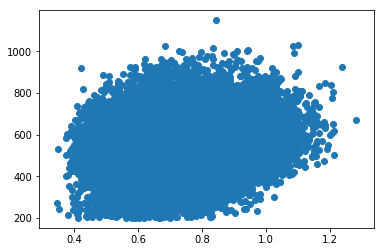

In [125]:
plt.scatter(vdf[vdf.estimated_weight_g > 200].depth, vdf[vdf.estimated_weight_g > 200].estimated_weight_g)

Text(0.5, 1.0, 'Cropper Recall: Width, Height pixels')

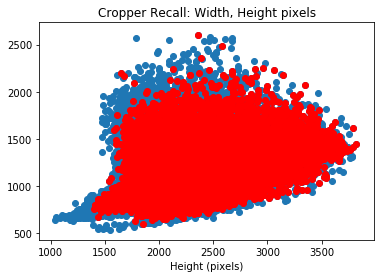

In [140]:
vdf2 = vdf

widths = []
heights = []

widths2 = []
heights2 = []

for index, row in vdf2.iterrows():
    widths.append(row['left_crop_metadata']['width'])
    heights.append(row['left_crop_metadata']['height'])
    if row['akpd_score'] > 0.95:
        widths2.append(row['left_crop_metadata']['width'])
        heights2.append(row['left_crop_metadata']['height'])

plt.scatter(widths, heights)
plt.scatter(widths2, heights2, color = 'red')

plt.xlabel('Width (pixels)')
plt.xlabel('Height (pixels)')
plt.title('Cropper Recall: Width, Height pixels')

2.8686429849220545

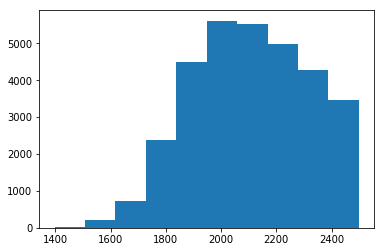

In [158]:
widths = np.array(widths2)

counts, bins, _ = plt.hist(widths[widths < 2500])

counts = np.array(counts)
bins = np.array(bins)

mask = bins[1:] < 2000

np.max(counts[mask]) / np.mean(counts[mask])

In [161]:
sum(widths > 2000) / len(widths)

.75 + .25 * 3 + 2 * 3 * .25

3.0

In [108]:
np.corrcoef(ddf.depth, ddf.estimated_weight_g), np.corrcoef(vdf.depth, vdf.estimated_weight_g)

(array([[1.        , 0.33808409],
        [0.33808409, 1.        ]]),
 array([[1.        , 0.39498642],
        [0.39498642, 1.        ]]))

In [110]:
np.sqrt(1 - .4 ** 2)

0.916515138991168

In [ ]:
df = df[~df.applymap(lambda x: x is None)['annotation']]

In [123]:
import math
from research.weight_estimation.keypoint_utils.optics import euclidean_distance, pixel2world, depth_from_disp, convert_to_world_point

lengths = []
depths = []
thetas = []
phis = []

for idx, row in vdf.iterrows():
    ann, cm = row.annotation, row.camera_metadata
    wkps = pixel2world(ann['leftCrop'], ann['rightCrop'], cm)
    depth = np.median([wkp[1] for wkp in wkps.values()])
    depths.append(depth)
    lengths.append(np.linalg.norm(wkps['UPPER_LIP'] - wkps['TAIL_NOTCH']))
    
    vector = wkps['PECTORAL_FIN'] - wkps['ANAL_FIN']
    x, y, z = vector / np.linalg.norm(vector)
    
    theta = math.atan(y / x) * np.sign(y)
    phi = math.acos(z)
    dtheta = math.degrees(theta)
    dphi = 90 - math.degrees(phi)
    thetas.append(dtheta)
    phis.append(dphi)

vdf['depth'] = depths
vdf['length'] = lengths
vdf['theta'] = thetas
vdf['phi'] = phis


In [80]:
import math
from research.weight_estimation.keypoint_utils.optics import euclidean_distance, pixel2world, depth_from_disp, convert_to_world_point

lengths = []
depths = []
thetas = []
phis = []

for idx, row in ddf.iterrows():
    ann, cm = row.annotation, row.camera_metadata
    wkps = pixel2world(ann['leftCrop'], ann['rightCrop'], cm)
    depth = np.median([wkp[1] for wkp in wkps.values()])
    depths.append(depth)
    lengths.append(np.linalg.norm(wkps['UPPER_LIP'] - wkps['TAIL_NOTCH']))
    
    vector = wkps['PECTORAL_FIN'] - wkps['ANAL_FIN']
    x, y, z = vector / np.linalg.norm(vector)
    
    theta = math.atan(y / x) * np.sign(y)
    phi = math.acos(z)
    dtheta = math.degrees(theta)
    dphi = 90 - math.degrees(phi)
    thetas.append(dtheta)
    phis.append(dphi)

ddf['depth'] = depths
ddf['length'] = lengths
ddf['theta'] = thetas
ddf['phi'] = phis


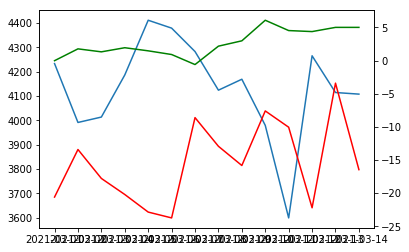

In [60]:
dates = sorted(list(set(vdf['date'])))

weights = []
thetas = []
phis = []

for date in dates:
    vdf2 = vdf[(vdf.date == date)]
    weights.append(np.mean(vdf2['estimated_weight_g']))
    thetas.append(np.mean(vdf2['theta']))
    phis.append(np.mean(vdf2['phi']))
    
    
fig, ax = plt.subplots()
ax2 = ax.twinx()

ax.plot(dates, weights)
ax2.plot(dates, thetas, color = 'red')
ax2.plot(dates, phis, color = 'green')

2021-03-15 4789.657109025596 471 69
2021-03-16 4880.702901317412 528 83
2021-03-17 4980.9264912400195 1517 186
2021-03-18 4921.637690028461 1924 307
2021-03-19 5257.1571292103945 1232 185
2021-03-20 5005.3619453932515 1622 187
2021-03-21 4847.244584287693 1650 306
2021-03-22 5131.372582104246 841 59
2021-03-23 5227.694568388602 805 68
2021-03-24 4919.285376866658 371 48
2021-03-25 4825.162280534135 1661 244
2021-03-26 4951.936902685298 990 144
2021-03-27 5051.886907645634 987 91
2021-03-28 5202.0679321782345 1243 145
2021-03-29 4869.129789629202 973 87
2021-03-30 5011.501991631169 1366 152
2021-03-31 4979.78878655256 2246 416
2021-04-01 5108.98673797355 863 68
2021-04-02 4999.292141976136 2489 606
2021-04-03 5233.385558381226 722 66
2021-04-04 5055.09728634799 1019 108
2021-04-05 5021.516645132606 1246 201
2021-04-06 4722.79637267715 1100 171
2021-04-07 4749.7178141946915 1770 385
2021-04-08 4972.030697390437 420 32


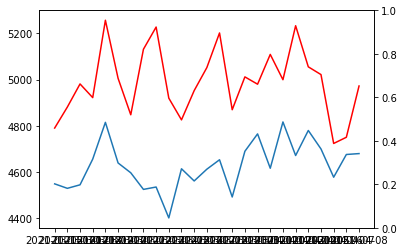

In [84]:
dates = sorted(list(set(ddf['date'])))

weights = []
weights_filtered = []
thetas = []
phis = []

for date in dates:
    ddf2 = ddf[(ddf.date == date) & (ddf.hour >= 9) & (ddf.hour <= 15)]
    ddf3 = ddf[(ddf.date == date) & (ddf.hour >= 9) & (ddf.hour <= 15) & (np.abs(ddf['theta']) < 10)]

    print(date, np.mean(ddf3['estimated_weight_g']), len(ddf2), len(ddf3))
    
    weights.append(np.mean(ddf2['estimated_weight_g']))
    weights_filtered.append(np.mean(ddf3['estimated_weight_g']))
    thetas.append(np.mean(ddf2['theta']))
    phis.append(np.mean(ddf2['phi']))
    
    
fig, ax = plt.subplots()
ax2 = ax.twinx()

ax.plot(dates, weights)
ax.plot(dates, weights_filtered, color = 'red')
# ax2.plot(dates, thetas, color = 'red')
# ax2.plot(dates, phis, color = 'green')

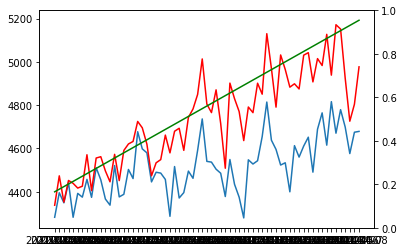

In [105]:
dates = sorted(list(set(vdf['date'])))

weights = []
weights_filtered = []
thetas = []
phis = []

for date in dates:
    ddf2 = vdf[(vdf.date == date) & (vdf.hour >= 9) & (vdf.hour <= 15)]
    ddf3 = vdf[(vdf.date == date) & (vdf.hour >= 9) & (vdf.hour <= 15) & (np.abs(vdf['theta']) < 20)]

#     print(date, np.mean(ddf3['estimated_weight_g']), len(ddf2), len(ddf3))
    
    weights.append(np.mean(ddf2['estimated_weight_g']))
    weights_filtered.append(np.mean(ddf3['estimated_weight_g']))
    thetas.append(np.mean(ddf2['theta']))
    phis.append(np.mean(ddf2['phi']))
    
    
fig, ax = plt.subplots()
ax2 = ax.twinx()

x = np.arange(0, len(dates))
y = 4400 + 12 * x

ax.plot(dates, weights)
ax.plot(dates, weights_filtered, color = 'red')
ax.plot(x, y, color = 'green')
# ax2.plot(dates, thetas, color = 'red')
# ax2.plot(dates, phis, color = 'green')

In [93]:
print(y[-1])

5192


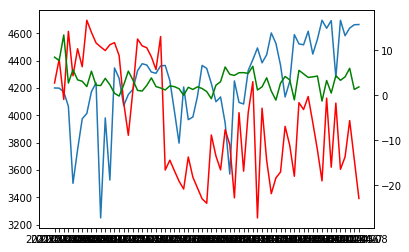

In [94]:
dates = sorted(list(set(vdf['date'])))

weights = []
thetas = []
phis = []

for date in dates:
    ddf2 = vdf[(vdf.date == date)]
    weights.append(np.mean(ddf2['estimated_weight_g']))
    thetas.append(np.mean(ddf2['theta']))
    phis.append(np.mean(ddf2['phi']))
    
    
fig, ax = plt.subplots()
ax2 = ax.twinx()

ax.plot(dates, weights)
ax2.plot(dates, thetas, color = 'red')
ax2.plot(dates, phis, color = 'green')

(array([0.00000000e+00, 1.00553914e-05, 3.26800222e-05, 5.02769572e-05,
        1.48317024e-04, 2.63954025e-04, 3.16744831e-04, 3.16744831e-04,
        4.17298745e-04, 3.34341766e-04, 2.23732460e-04, 1.35747785e-04,
        8.04431316e-05, 6.78738923e-05, 3.26800222e-05, 1.00553914e-05,
        7.54154359e-06, 5.02769572e-06, 1.00553914e-05, 2.51384786e-06]),
 array([1665.66193104, 2071.16299868, 2476.66406631, 2882.16513395,
        3287.66620159, 3693.16726923, 4098.66833687, 4504.16940451,
        4909.67047215, 5315.17153978, 5720.67260742, 6126.17367506,
        6531.6747427 , 6937.17581034, 7342.67687798, 7748.17794561,
        8153.67901325, 8559.18008089, 8964.68114853, 9370.18221617,
        9775.68328381]),
 <a list of 20 Patch objects>)

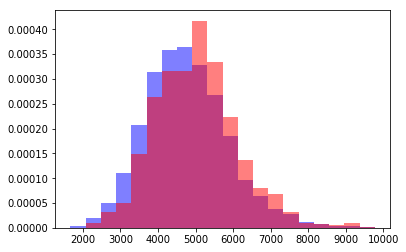

In [102]:
date = '2021-04-02'
date2 = '2021-04-05'
ddf2 = vdf[(vdf.date >= date) & (vdf.date <= date2) & (vdf.hour >= 9) & (vdf.hour <= 15)]
ddf3 = vdf[(vdf.date >= date) & (vdf.date <= date2) & (vdf.hour >= 9) & (vdf.hour <= 15) & (np.abs(vdf['theta']) < 10)]


counts, bins, _ = plt.hist(ddf2.estimated_weight_g, density = True, color = 'blue', bins = 20, alpha = 0.5)
plt.hist(ddf3.estimated_weight_g, density = True, color = 'red', bins = bins, alpha = 0.5)

In [49]:
for d, t in zip(dates, thetas):
    print(d, t)

2021-02-01 3.492865836721234
2021-02-02 8.030745162702733
2021-02-03 -0.16607104044452306
2021-02-04 14.413205304142306
2021-02-05 4.659428058353118
2021-02-06 10.3095460392647
2021-02-07 6.756374153346911
2021-02-08 17.003330653227913
2021-02-09 14.091647407925139
2021-02-10 11.56538504640551
2021-02-11 10.723156029119524
2021-02-12 10.577413782277448
2021-02-13 10.95428952414679
2021-02-14 11.700095023057052
2021-02-15 8.908331919002455
2021-02-16 -1.8547776246264738
2021-02-17 -8.90709517996251
2021-02-18 1.7453310433849298
2021-02-19 12.8681612541829
2021-02-20 11.202604787943725
2021-02-21 10.794897953174083
2021-02-22 8.544066573545773
2021-02-23 5.8223282413029525
2021-02-24 12.87703228548985
2021-02-25 -16.150899009469857
2021-02-26 -14.256424178155353
2021-02-27 -16.36341418882726
2021-02-28 -18.52824069706717
2021-03-01 -20.60291616373231
2021-03-02 -13.42350287731236
2021-03-03 -17.79146068341159
2021-03-04 -20.214699816377248
2021-03-05 -22.86835624740475
2021-03-06 -23.749

In [69]:
dates = np.array(dates)
thetas = np.array(thetas)
weights = np.array(weights)

# mask = dates > 0 # '2021-03-01'

np.corrcoef(thetas, weights)

array([[ 1.        , -0.24096802],
       [-0.24096802,  1.        ]])

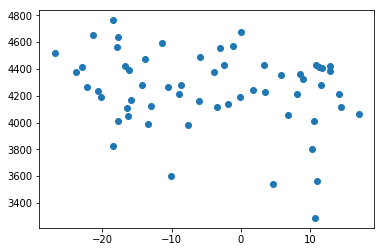

In [70]:
plt.scatter(thetas, weights)

In [ ]:
from research.weight_estimation.keypoint_utils.optics import euclidean_distance, pixel2world, depth_from_disp, convert_to_world_point

lengths = []
depths = []

for idx, row in df.iterrows():
    ann, cm = row.annotation, row.camera_metadata
    wkps = pixel2world(ann['leftCrop'], ann['rightCrop'], cm)
    depth = np.median([wkp[1] for wkp in wkps.values()])
    depths.append(depth)
    lengths.append(np.linalg.norm(wkps['UPPER_LIP'] - wkps['TAIL_NOTCH']))

df['depth'] = depths
df['length'] = lengths



In [ ]:
import json, os
from research.utils.data_access_utils import S3AccessUtils

model1_url = 'https://aquabyte-models.s3-us-west-1.amazonaws.com/biomass/playground/nn_epoch_798_v2.pb'
model2_url = 'https://aquabyte-models.s3-us-west-1.amazonaws.com/biomass/trained_models/2020-11-27T00-00-00/weight_model_synthetic_data.pb'

s3 = S3AccessUtils('/root/data', json.load(open(os.environ['AWS_CREDENTIALS'])))

weight_model1_f, _, _ = s3.download_from_url(model1_url)
weight_model2_f, _, _ = s3.download_from_url(model2_url)
kf_model_f, _, _ = s3.download_from_url('https://aquabyte-models.s3-us-west-1.amazonaws.com/k-factor/playground/kf_predictor_v2.pb')

weight_estimator1 = WeightEstimator(weight_model1_f, kf_model_f)
weight_estimator2 = WeightEstimator(weight_model2_f, kf_model_f)

In [ ]:
weights1 = []
weights2 = []

count = 0

for idx, row in vdf.iterrows():
    count = count + 1
    
    if count % 10000 == 0:
        print(count)
    
    annotation = row.annotation
    if not annotation:
        weights.append(None)
        continue
    camera_metadata = row.camera_metadata

    camera_metadata_obj = CameraMetadata(
        focal_length=camera_metadata['focalLength'],
        focal_length_pixel=camera_metadata['focalLengthPixel'],
        baseline_m=camera_metadata['baseline'],
        pixel_count_width=camera_metadata['pixelCountWidth'],
        pixel_count_height=camera_metadata['pixelCountHeight'],
        image_sensor_width=camera_metadata['imageSensorWidth'],
        image_sensor_height=camera_metadata['imageSensorHeight']
    )

    weight1, length, kf = weight_estimator1.predict(annotation, camera_metadata_obj)
    weight2, length, kf = weight_estimator2.predict(annotation, camera_metadata_obj)

    weights1.append(weight1)
    weights2.append(weight2)

In [ ]:
df['weights1'] = weights1
df['weights2'] = weights2

In [ ]:
vdf['weights1'] = weights1
vdf['weights2'] = weights2

In [ ]:
from datetime import datetime

dates = sorted(list(set(list(df.date))))
plot_dates = [ datetime.strptime(d, '%Y-%m-%d') for d in dates ]

weights1 = []
weights2 = []
weights3 = []

for date in dates:
#     mask1 = (df.akpd_score > 0.95) & (df.hour >= 8) & (df.hour <= 16) & (df.date == date)
#     mask2 = (df.akpd_score > 0.95) & (df.hour >= 8) & (df.hour <= 16) & (df.date == date)
#     mask3 = (df.akpd_score > 0.95) & (df.hour >= 8) & (df.hour <= 16) & (df.date == date)
    mask1 = (df.akpd_score > 0.95) & (df.hour >= 5) & (df.hour <= 11) & (df.date == date)
    mask2 = (df.akpd_score > 0.95) & (df.hour >= 5) & (df.hour <= 11) & (df.date == date)
    mask3 = (df.akpd_score > 0.95) & (df.hour >= 5) & (df.hour <= 11) & (df.date == date)
    
    weights1.append(np.mean(df[mask1]['weights1']))
    weights2.append(np.mean(df[mask2]['weights2']))
    weights3.append(np.mean(df[mask3]['estimated_weight_g']))

In [ ]:
from matplotlib.dates import DateFormatter, WeekdayLocator, MONDAY

fig, ax = plt.subplots(figsize=(20, 10))

ax.xaxis.set_major_locator(WeekdayLocator(MONDAY))
ax.xaxis.set_major_formatter(DateFormatter('%m/%d'))

ax.set_xlabel('Date')
ax.plot(plot_dates, weights1, label = 'Old Model')
ax.plot(plot_dates, weights2, label = 'New Model')
ax.plot(plot_dates, weights3, label = 'Current Model')
ax.legend()

In [ ]:
# mask = (df.akpd_score > 0.95) & (df.date == '2020-08-25')
mask = (df.akpd_score > 0.95) & (df.date == '2020-05-10')
plt.hist(df[mask].hour, bins = 13)

In [ ]:
# mask = (df.akpd_score > 0.95) & (df.hour >= 5) & (df.hour <= 16) & (df.date == '2020-08-25')
mask = (df.akpd_score > 0.95) & (df.hour >= 5) & (df.hour <= 11) & (df.date == '2020-05-10')

print(np.mean(df[mask]['weights2']))
# print(np.mean(vikane_gt))
print(np.mean(langoy_gt))

fig, ax = plt.subplots(figsize=(10, 5))
# count, bins, _ = ax.hist(vikane_gt, density = True, bins = 20, alpha = 0.5, color = 'blue')
count, bins, _ = ax.hist(langoy_gt, density = True, bins = 30, alpha = 0.5, color = 'blue')
ax.hist(df[mask]['weights2'], bins = bins, density = True, alpha = 0.5, color = 'red')

In [ ]:
# mask = (df.akpd_score > 0.95) & (df.hour >= 5) & (df.hour <= 16) & (df.date == '2020-08-25')
mask = (df.akpd_score > 0.95) & (df.hour >= 5) & (df.hour <= 11) & (df.date == '2020-05-10')

print(np.mean(df[mask]['weights2']))
# print(np.mean(vikane_gt))
print(np.mean(langoy_modified))

fig, ax = plt.subplots(figsize=(10, 5))
# count, bins, _ = ax.hist(vikane_gt, density = True, bins = 20, alpha = 0.5, color = 'blue')
count, bins, _ = ax.hist(langoy_modified, density = True, bins = 30, alpha = 0.5, color = 'blue')
ax.hist(df[mask]['weights2'], bins = bins, density = True, alpha = 0.5, color = 'red')

In [ ]:
mask = (df.akpd_score > 0.95) & (df.hour >= 5) & (df.hour <= 16) & (df.date == '2020-08-25')

print(np.mean(df[mask]['weights2']))
print(np.mean(vikane_gt))

fig, ax = plt.subplots(figsize=(10, 5))
count, bins, _ = ax.hist(vikane_gt, density = True, bins = 20, alpha = 0.5, color = 'blue')
ax.hist(df[mask]['weights2'], bins = bins, density = True, alpha = 0.5, color = 'red')

In [ ]:
import math
lower, upper = np.percentile(df[mask]['weights2'], 10), np.percentile(df[mask]['weights2'], 90)
lower, upper = int(math.ceil(lower / 100.0)) * 100, int(math.ceil(upper / 100.0)) * 100

In [ ]:
mask2 = (df[mask]['weights2'] >= lower) & (df[mask]['weights2'] <= upper)
_, floc, _ = stats.weibull_min.fit(df[mask][mask2]['depth'])

In [ ]:
mask = (df.akpd_score > 0.95) & (df.hour >= 5) & (df.hour <= 16) & (df.date == '2020-08-25')

from scipy import stats

buckets = np.linspace(lower, upper, 100)

results = []

for bucket in buckets:
    min_bucket = bucket - 1000
    max_bucket = bucket + 1000
    mask3 = (df[mask].estimated_weight_g > min_bucket) & (df[mask].estimated_weight_g < max_bucket)
    res = stats.weibull_min.fit(df[mask][mask3].depth, floc = floc)
    results.append(res)
    
results = np.array(results)


In [ ]:
import statsmodels.api as sm

Y0 = results[:,0]
Y2 = results[:,2]
X = buckets
X = sm.add_constant(X)
model0 = sm.OLS(Y0,X)
model2 = sm.OLS(Y2,X)
m0 = model0.fit()
m2 = model2.fit()

In [ ]:
plt.figure(figsize=(20, 5))
plt.plot(buckets, results[:,0])
plt.figure(figsize=(20, 5))
plt.plot(buckets, results[:,2])

In [ ]:
def get_prob(depth, weight):
    v0 = m0.predict([1, weight])
    v1 = floc
    v2 = m2.predict([1, weight])
    
    x = np.linspace(0, 3, 5000)
    x_pdf = stats.weibull_min.pdf(x, v0, v1, v2)
    x_max = max(x_pdf)
    avg_depth = x[np.argmax(x_pdf)]
    
    prob = stats.weibull_min.pdf(depth, v0, v1, v2)[0]
#     if depth >= avg_depth:
#         prob = x_max
    
    return prob / x_max

weights = df[mask].weights2

weights_weight = []
weights_prob = []

for i, row in df[mask].iterrows():
    prob = get_prob(row['depth'], row['weights2'])
    
    if prob < 0.01:
        print(row['depth'], row['weights2'])
    else:
        weights_weight.append(row['weights2'])
        weights_prob.append(prob)
    
weights_weight = np.array(weights_weight)
weights_prob = np.array(weights_prob)

In [ ]:
w1 = np.mean(weights)
w2 = np.sum(weights_weight / weights_prob) / np.sum(1 / weights_prob)
wgt = np.mean(vikane_gt)

print(w1, w2, wgt)
print((w1 - wgt) / wgt)
print((w2 - wgt) / wgt)

In [ ]:
counts1, bins, _ = plt.hist(vikane_gt, density = True, bins = 20, alpha = 0.5, color = 'blue')

counts = []

mask2 = df[mask].depth < 2

for index, _ in enumerate(counts1):
    if index == len(bins) - 1:
        continue
        
    bin_lower = bins[index]
    bin_upper = bins[index + 1]
        
    mask3 = (weights_weight[mask2] >= bin_lower) & (weights_weight[mask2] < bin_upper)
    count = np.sum(1 / weights_prob[mask2][mask3])
    counts.append(count)
    
counts = np.array(counts) / np.sum(1 / weights_prob[mask2])

counts2, bins2, _ = plt.hist(bins[0:-1], weights = counts, bins = bins, density = True, alpha = 0.5, color = 'red')

In [ ]:
mask = (df.akpd_score > 0.95) & (df.hour >= 4) & (df.hour <= 17) & (df.date == '2020-08-25') & (df.depth <= np.median(df.depth))
count, bins, _ = plt.hist(vikane_gt, density = True, bins = 20, alpha = 0.5, color = 'blue')
plt.hist(df[mask]['weights2'], bins = bins, density = True, alpha = 0.5, color = 'red')

In [ ]:
mask = (df.akpd_score > 0.95) & (df.hour >= 4) & (df.hour <= 17) & (df.date == '2020-08-25') & (df.prob > 1)
count, bins, _ = plt.hist(vikane_gt, density = True, bins = 20, alpha = 0.5, color = 'blue')
plt.hist(df[mask]['weights2'], bins = bins, density = True, alpha = 0.5, color = 'red')

In [ ]:
mask = (df.akpd_score > 0.95) & (df.hour >= 4) & (df.hour <= 17) & (df.date == '2020-08-25') & (df.prob < 0.5)
count, bins, _ = plt.hist(vikane_gt, density = True, bins = 20, alpha = 0.5, color = 'blue')
plt.hist(df[mask]['weights2'], bins = bins, density = True, alpha = 0.5, color = 'red')

In [ ]:
mask = (df.akpd_score > 0.95) & (df.hour >= 4) & (df.hour <= 17) & (df.date == '2020-08-25') 
count, bins, _ = plt.hist(vikane_gt, density = True, bins = 20, alpha = 0.5, color = 'blue')
plt.hist(df[mask]['weights2'], bins = bins, density = True, alpha = 0.5, color = 'red')

In [ ]:
plt.figure(figsize=(20, 10))
x = np.linspace(0, 3, 5000)
plt.plot(x, stats.weibull_min.pdf(x, *stats.weibull_min.fit(df[mask]['depth'])))
plt.hist(df[mask]['depth'], bins = 30, alpha = 0.5, density = True)

In [ ]:
res = stats.probplot(df[mask].depth, dist=stats.weibull_min, sparams=stats.weibull_min.fit(df[mask]['depth']), plot=plt)


In [ ]:
mask = (df.akpd_score > 0.95) & (df.hour >= 5) & (df.hour <= 16) & (df.date == '2020-08-29')
plt.hist(df[mask]['depth'], bins = 20)

In [ ]:
mask = (df.akpd_score > 0.95) & (df.hour >= 15) & (df.hour <= 17) & (df.date == '2020-08-29')
plt.hist(df[mask]['depth'], bins = 20)

In [ ]:
mask = (df.akpd_score > 0.95) & (df.hour >= 7) & (df.hour <= 14) & (df.date == '2020-08-29')
plt.hist(df[mask]['depth'], bins = 20)

In [ ]:
mask = (df.akpd_score > 0.95) & (df.hour >= 4) & (df.hour <= 6) & (df.date == '2020-08-25')
plt.scatter(df[mask]['depth'], df[mask]['weights2'])

In [ ]:
df[(df.weights2 > 7000)].iloc[0]

In [ ]:
probs = []

for index, row in df.iterrows():
    L = row['length']
    D = row['depth']
    V = L
    F = 1

    p = (1.04 * D - L)*F / V
    probs.append(p)
    
df['prob'] = probs

In [ ]:
mask = (df.akpd_score > 0.95) & (df.hour >= 5) & (df.hour <= 16) & (df.date == '2020-08-25')

plt.scatter(df[mask]['depth'], df[mask]['weights2'], c = df[mask]['prob'])
plt.colorbar()

In [ ]:
mask = (df.akpd_score > 0.95) & (df.hour >= 5) & (df.hour <= 16) 

plt.scatter(df[mask]['depth'], df[mask]['weights2'], c = df[mask]['prob'])
plt.colorbar()

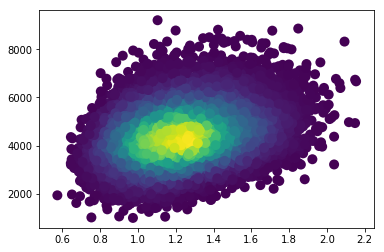

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

df = ddf

mask = (df.akpd_score > 0.95) & (df.hour >= 9) & (df.hour <= 13) 

# Generate fake data
x = df[mask]['depth']
y = df[mask]['estimated_weight_g']

# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

fig, ax = plt.subplots()
ax.scatter(x, y, c=z, s=100, edgecolor='')
plt.show()

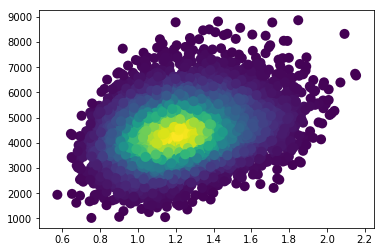

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# mask = (df.akpd_score > 0.95) & (df.hour >= 5) & (df.hour <= 16) & (df.date >= '2020-08-20') & (df.date <= '2020-08-25')
# mask = (df.akpd_score > 0.95) & (df.hour >= 5) & (df.hour <= 16) & (df.date == '2020-08-25')
mask = (df.akpd_score > 0.95) & (df.hour >= 9) & (df.hour <= 13) & (df.date <= '2021-02-20')

# Generate fake data
x = df[mask]['depth']
y = df[mask]['estimated_weight_g']
# l = df[mask]['length']

# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

fig, ax = plt.subplots()
ax.scatter(x, y, c=z, s=100, edgecolor='')
plt.show()

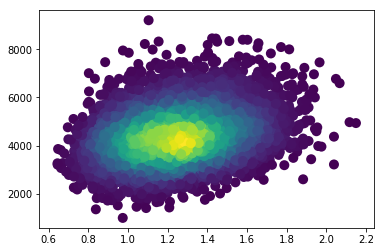

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# mask = (vdf.akpd_score > 0.95) & (vdf.hour >= 5) & (vdf.hour <= 16) & (vdf.date == '2020-08-25')
mask = (df.akpd_score > 0.95) & (df.hour >= 9) & (df.hour <= 13) & (df.date >= '2021-02-21')

# Generate fake data
x = df[mask]['depth']
y = df[mask]['estimated_weight_g']
# l = df[mask]['length']

# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

fig, ax = plt.subplots()
ax.scatter(x, y, c=z, s=100, edgecolor='')
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# mask = (df.akpd_score > 0.95) & (df.hour >= 5) & (df.hour <= 16) & (df.date >= '2020-08-20') & (df.date <= '2020-08-25')
# mask = (df.akpd_score > 0.95) & (df.hour >= 5) & (df.hour <= 11) & (df.date <= '2020-05-10')
mask = (df.akpd_score > 0.95) & (df.hour >= 5) & (df.hour <= 11) & (df.date == '2020-05-10')
# mask = mask & (df.depth < np.mean(df.depth))

# Generate fake data
x = df[mask]['depth']
y = df[mask]['weights2']
l = df[mask]['length']

# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

fig, ax = plt.subplots()
ax.scatter(x, y, c=z, s=100, edgecolor='')
plt.show()

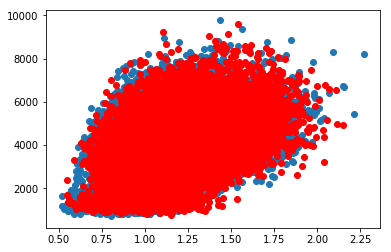

In [10]:
mask = (ddf.akpd_score > 0.95) & (ddf.date <= '2021-02-20')

x = ddf[mask]['depth']
y = ddf[mask]['estimated_weight_g']

mask2 = (ddf.akpd_score > 0.95) & (ddf.date > '2021-02-20')

x2 = ddf[mask2]['depth']
y2 = ddf[mask2]['estimated_weight_g']

plt.scatter(x, y)
plt.scatter(x2, y2, color = 'red')

(array([2.47612811e-04, 2.88700211e-03, 7.44471045e-03, 1.07915649e-02,
        1.14745409e-02, 1.07099343e-02, 8.04605585e-03, 3.52372077e-03,
        7.72769652e-04, 8.43516169e-05]),
 array([-89.50228242, -71.63948198, -53.77668154, -35.9138811 ,
        -18.05108066,  -0.18828022,  17.67452022,  35.53732066,
         53.4001211 ,  71.26292154,  89.12572198]),
 <a list of 10 Patch objects>)

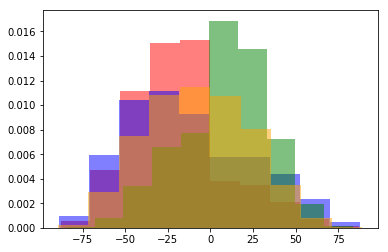

In [25]:
mask = (vdf.akpd_score > 0.95) & (vdf.date <= '2021-03-07')

x = vdf[mask]['depth']
y = vdf[mask]['theta']

mask2 = (vdf.akpd_score > 0.95) & (vdf.date > '2021-03-07')

x2 = vdf[mask2]['depth']
y2 = vdf[mask2]['theta']

# plt.scatter(x, y)
# plt.scatter(x2, y2, color = 'red')

plt.hist(y, alpha = 0.5, density = True, color = 'red')
plt.hist(y2, alpha = 0.5, density = True, color = 'blue')
plt.hist(y3, alpha = 0.5, density = True, color = 'green')
plt.hist(y4, alpha = 0.5, density = True, color = 'orange')

(3.367539470575222, 13.57935251986041)

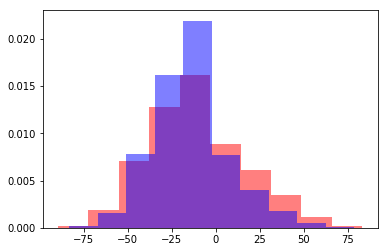

In [32]:
mask = (ddf.akpd_score > 0.95) & (ddf.date <= '2021-02-20')
mask = (ddf.akpd_score > 0.95) & (ddf.date <= '2021-02-07')

x3 = ddf[mask]['depth']
y3 = ddf[mask]['theta']

mask2 = (ddf.akpd_score > 0.95) & (ddf.date > '2021-02-20')
mask2 = (ddf.akpd_score > 0.95) & (ddf.date > '2021-02-07') & (ddf.date < '2021-02-15')

x4 = ddf[mask2]['depth']
y4 = ddf[mask2]['theta']

# plt.scatter(x, y)
# plt.scatter(x2, y2, color = 'red')

plt.hist(y3, alpha = 0.5, density = True, color = 'red')
plt.hist(y4, alpha = 0.5, density = True, color = 'blue')

np.mean(y3) - np.mean(y4), np.mean(y) - np.mean(y2)

(array([0.02878445, 0.30905413, 0.95200793, 1.55799642, 1.64889469,
        1.07017568, 0.50175847, 0.13574142, 0.02575451, 0.00363593]),
 array([0.54510794, 0.70552365, 0.86593935, 1.02635505, 1.18677076,
        1.34718646, 1.50760217, 1.66801787, 1.82843357, 1.98884928,
        2.14926498]),
 <a list of 10 Patch objects>)

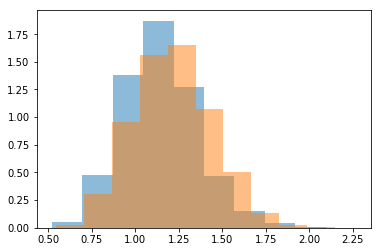

In [14]:
mask = (ddf.akpd_score > 0.95) & (ddf.date <= '2021-02-20')

x = ddf[mask]['depth']
y = ddf[mask]['phi']

mask2 = (ddf.akpd_score > 0.95) & (ddf.date > '2021-02-20')

x2 = ddf[mask2]['depth']
y2 = ddf[mask2]['phi']

# plt.scatter(x, y)
# plt.scatter(x2 * 1.1, y2, color = 'red')

plt.hist(x, alpha = 0.5, density = True)
plt.hist(x2, alpha = 0.5, density = True)

(array([1.45919289e-04, 8.20167036e-04, 4.68451233e-03, 1.87179225e-02,
        3.54080701e-02, 2.98631372e-02, 1.06672032e-02, 2.70202269e-03,
        4.78011463e-04, 3.52218972e-05]),
 array([-44.40796668, -34.74820173, -25.08843679, -15.42867184,
         -5.76890689,   3.89085805,  13.550623  ,  23.21038794,
         32.87015289,  42.52991784,  52.18968278]),
 <a list of 10 Patch objects>)

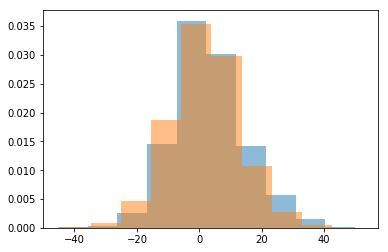

In [15]:
plt.hist(y, alpha = 0.5, density = True)
plt.hist(y2, alpha = 0.5, density = True)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

mask = (ddf.akpd_score > 0.95) & (ddf.date > '2021-01-20') & (ddf.date <= '2021-02-05')

# Generate fake data
x = ddf[mask]['depth']
y = ddf[mask]['estimated_weight_g']
# l = ddf[mask]['length']

# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

fig, ax = plt.subplots()
ax.scatter(x, y, c=z, s=100, edgecolor='')

d = np.arange(0.75, 2.75, 0.01)
ax.plot(d, 600 + 600 * d ** 3, 'red')
ax.plot(d, 1500 + 300 * d ** 3, 'cyan')

plt.xlim([.5, 3])
plt.ylim([0, 15000])

plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

mask = (ddf.akpd_score > 0.95) & (ddf.date > '2021-01-20') & (ddf.date <= '2021-02-05') & (ddf.depth < 2.2)

# Generate fake data
x = ddf[mask]['depth']
y = ddf[mask]['estimated_weight_g']
# l = ddf[mask]['length']

# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

fig, ax = plt.subplots()
ax.scatter(x, y, c=z, s=100, edgecolor='')

d = np.arange(0.75, 2.5, 0.01)
ax.plot(d, 600 + 600 * d ** 3, 'red')
ax.plot(d, 1500 + 300 * d ** 3, 'cyan')

plt.xlim([.5, 3])
plt.ylim([0, 15000])

plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

mask = (ddf.akpd_score > 0.95) & (ddf.date > '2021-02-05') & (ddf.date <= '2021-02-15')

# Generate fake data
x = ddf[mask]['depth']
y = ddf[mask]['estimated_weight_g']
# l = ddf[mask]['length']

# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

fig, ax = plt.subplots()
ax.scatter(x, y, c=z, s=100, edgecolor='')

d = np.arange(0.75, 2.75, 0.01)
ax.plot(d, 600 + 600 * d ** 3, 'red')
ax.plot(d, 1500 + 300 * d ** 3, 'cyan')

plt.xlim([.5, 3])
plt.ylim([0, 15000])

plt.show()

In [ ]:
cutoff = .0001
# cutoff = 0
np.percentile(x[z > cutoff], 5), np.percentile(x[z > cutoff], 95)

In [ ]:
cutoff = .0001
# cutoff = 0
np.percentile(x[z > cutoff], 5), np.percentile(x[z > cutoff], 95)

In [ ]:
sum(z), np.mean(z), len(z)

In [ ]:
sum(z), np.mean(z), len(z)

In [ ]:
sum(z), np.mean(z), len(z)

In [ ]:
plt.hist(z[(x > 1) & (x < 1.1)])

In [ ]:
plt.hist(y, bins = 30)

In [ ]:
plt.hist(x, bins = 30)

In [ ]:
plt.scatter(l, y)

In [ ]:
plt.scatter(l, x)

In [ ]:
fig, ax = plt.subplots()
ax.scatter(x, y, c=z, s=100, edgecolor='')

d = np.arange(0.6, 1.2, 0.01)
ax.plot(d, 5000 * d ** 3)
plt.show()

In [ ]:
from scipy import spatial

x_sd = np.std(x)
y_sd = np.std(y)

xy_kd = [(x_ / x_sd, y[i] / y_sd) for i, x_ in enumerate(x) ]

distance, index = spatial.KDTree(xy_kd).query([(1 / x_sd, 6000 / y_sd)], k = 10)
print(distance)
print(index)

In [ ]:
for i in index[0]:
    print(i)
    x_, y_ = xy_kd[i]
    print(x_ * x_sd, y_ * y_sd, z[i])

In [ ]:
from scipy import spatial

x_sd = np.std(x)
y_sd = np.std(y)

xy_kd = [(x_ / x_sd, y[i] / y_sd) for i, x_ in enumerate(x) ]

kd_tree = spatial.KDTree(xy_kd)

def get_prob(weight, depth):
    distance, index = kd_tree.query([(depth / x_sd, weight / y_sd)], k = 10)
    
    return np.mean([ z[i] for i in index[0] ])

In [ ]:
mask = (df.akpd_score > 0.95) & (df.hour >= 5) & (df.hour <= 16) & (df.date == '2020-08-25')

weights = df[mask].weights2

weights_weight = []
weights_prob = []

count = 0

for i, row in df[mask].iterrows():
    count = count + 1
    
#     if count % 100 == 0:
#         print('%i out of %i' % (count, sum(mask)))
        
#     prob = get_prob(row['weights2'], row['depth'])
    prob = get_final_prob(row['weights2'], row['depth'])
    
#     if prob < 0.01:
#         print(row['depth'], row['weights2'])
#     else:
    weights_weight.append(row['weights2'])
    weights_prob.append(prob)
    
weights_weight = np.array(weights_weight) * 1.1
weights_prob = np.array(weights_prob)

In [ ]:
mask = (df.akpd_score > 0.95) & (df.hour >= 5) & (df.hour <= 11) & (df.date == '2020-05-10') & (df.depth < 1.2)

weights = df[mask].weights2

weights_weight = []
weights_prob = []

count = 0

for i, row in df[mask].iterrows():
    count = count + 1
    
#     if count % 100 == 0:
#         print('%i out of %i' % (count, sum(mask)))
        
    prob = get_prob(row['weights2'], row['depth'])
#     prob = get_final_prob(row['weights2'], row['depth'])
#     prob = 1
    
    if np.isnan(prob):
        print(row['depth'], row['weights2'])
    else:
        weights_weight.append(row['weights2'])
        weights_prob.append(prob)
    
weights_weight = np.array(weights_weight)
weights_prob = np.array(weights_prob)

In [ ]:
w1 = np.mean(weights)
w2 = np.sum(weights_weight / weights_prob) / np.sum(1 / weights_prob)
# wgt = np.mean(vikane_gt)
wgt = np.mean(langoy_gt)

print(w1, w2, wgt)
print((w1 - wgt) / wgt)
print((w2 - wgt) / wgt)

In [ ]:
counts1, bins, _ = plt.hist(vikane_gt, density = True, bins = 30, alpha = 0.5, color = 'blue')

counts = []

for index, _ in enumerate(counts1):
    if index == len(bins) - 1:
        continue
        
    bin_lower = bins[index]
    bin_upper = bins[index + 1]
        
    mask3 = (weights_weight >= bin_lower) & (weights_weight < bin_upper)
    count = np.sum(1 / weights_prob[mask3])
    counts.append(count)
    
counts = np.array(counts) / np.sum(1 / weights_prob)

counts2, bins2, _ = plt.hist(bins[0:-1], weights = counts, bins = bins, density = True, alpha = 0.5, color = 'red')

In [ ]:
counts1, bins, _ = plt.hist(vikane_modified, density = True, bins = 30, alpha = 0.5, color = 'blue')

counts = []

for index, _ in enumerate(counts1):
    if index == len(bins) - 1:
        continue
        
    bin_lower = bins[index]
    bin_upper = bins[index + 1]
        
    mask3 = (weights_weight >= bin_lower) & (weights_weight < bin_upper)
    count = np.sum(1 / weights_prob[mask3])
    counts.append(count)
    
counts = np.array(counts) / np.sum(1 / weights_prob)

counts2, bins2, _ = plt.hist(bins[0:-1], weights = counts, bins = bins, density = True, alpha = 0.5, color = 'red')

In [ ]:
counts1, bins, _ = plt.hist(langoy_modified, density = True, bins = 30, alpha = 0.5, color = 'blue')

counts = []

for index, _ in enumerate(counts1):
    if index == len(bins) - 1:
        continue
        
    bin_lower = bins[index]
    bin_upper = bins[index + 1]
        
    mask3 = (weights_weight >= bin_lower) & (weights_weight < bin_upper)
    count = np.sum(1 / weights_prob[mask3])
    counts.append(count)
    
counts = np.array(counts) / np.sum(1 / weights_prob)

counts2, bins2, _ = plt.hist(bins[0:-1], weights = counts, bins = bins, density = True, alpha = 0.5, color = 'red')

In [ ]:
# mask = (df.akpd_score > 0.95) & (df.hour >= 5) & (df.hour <= 16) & (df.date == '2020-08-25')
mask = (df.akpd_score > 0.95) & (df.hour >= 5) & (df.hour <= 11) & (df.date == '2020-05-10') & (df.depth >= 1.1) & (df.depth <= 1.6)

a, b = np.mean(df[mask]['weights2']), np.mean(langoy_gt)

print(a)
print(b)
print((a - b) / b)

fig, ax = plt.subplots(figsize=(6, 3))
# count, bins, _ = ax.hist(vikane_gt, density = True, bins = 20, alpha = 0.5, color = 'blue')
count, bins, _ = ax.hist(langoy_modified, density = True, bins = 30, alpha = 0.5, color = 'blue')
ax.hist(df[mask]['weights2'], bins = bins, density = True, alpha = 0.5, color = 'red')

In [ ]:
# mask = (df.akpd_score > 0.95) & (df.hour >= 5) & (df.hour <= 16) & (df.date == '2020-08-25')
mask = (df.akpd_score > 0.95) & (df.hour >= 5) & (df.hour <= 11) & (df.date == '2020-05-10')

a, b = np.mean(df[mask]['weights2']), np.mean(langoy_modified)

print(a)
print(b)
print((a - b) / b)

fig, ax = plt.subplots(figsize=(6, 3))
# count, bins, _ = ax.hist(vikane_gt, density = True, bins = 20, alpha = 0.5, color = 'blue')
count, bins, _ = ax.hist(langoy_modified, density = True, bins = 30, alpha = 0.5, color = 'blue')
ax.hist(df[mask]['weights2'], bins = bins, density = True, alpha = 0.5, color = 'red')

In [ ]:
mask = (vdf.akpd_score > 0.95) & (vdf.hour >= 5) & (vdf.hour <= 16) & (vdf.date == '2020-08-25') & (vdf.depth >= 0.8) & (vdf.depth <= 1.4)

a, b = np.mean(vdf[mask]['weights2']), np.mean(vikane_modified)

print(a)
print(b)
print((a - b) / b)

fig, ax = plt.subplots(figsize=(6, 3))
count, bins, _ = ax.hist(vikane_gt, density = True, bins = 20, alpha = 0.5, color = 'blue')
ax.hist(vdf[mask]['weights2'], bins = bins, density = True, alpha = 0.5, color = 'red')

In [ ]:
mask = (vdf.akpd_score > 0.95) & (vdf.hour >= 5) & (vdf.hour <= 16) & (vdf.date == '2020-08-25')

a, b = np.mean(vdf[mask]['weights2']), np.mean(vikane_modified)
              
print(a)
print(b)
print((a - b) / b)

fig, ax = plt.subplots(figsize=(6, 3))
count, bins, _ = ax.hist(vikane_gt, density = True, bins = 20, alpha = 0.5, color = 'blue')
ax.hist(vdf[mask]['weights2'], bins = bins, density = True, alpha = 0.5, color = 'red')

In [ ]:
mask = (df.akpd_score > 0.95) & (df.hour >= 5) & (df.hour <= 11) & (df.date == '2020-05-10')
mask_alt = (df.akpd_score > 0.95) & (df.hour >= 5) & (df.hour <= 11) & (df.date == '2020-05-10') & (df.depth >= 1.1) & (df.depth <= 1.6)

buckets = np.arange(0, 14000, 1000)

num = 50

sds = np.arange(0, 1000, 100)
# sds = np.arange(0, .1, .01)

# for sd in sds:
#     diff1 = []
#     diff2 = []
        
# for i in np.arange(0, num):
sd = 500
langoy_m = langoy_gt + np.random.normal(0, sd, len(langoy_gt))
#     langoy_m = langoy_gt * np.random.normal(1, sd, len(langoy_gt))



for bucket in buckets:
    lower_bucket = bucket
    upper_bucket = bucket + 1000

    mask1 = (langoy_gt >= lower_bucket) & (langoy_gt < upper_bucket)
    mask2 = (langoy_m >= lower_bucket) & (langoy_m < upper_bucket)

    gt_pct1 = np.sum(mask1) / len(langoy_gt)
    gt_pct2 = np.sum(mask2) / len(langoy_m)

    mask3 = (df[mask]['weights2'] >= lower_bucket) & (df[mask]['weights2'] < upper_bucket)
    a_pct = np.sum(mask3) / np.sum(mask)

    mask4 = (df[mask_alt]['weights2'] >= lower_bucket) & (df[mask_alt]['weights2'] < upper_bucket)
    b_pct = np.sum(mask4) / np.sum(mask_alt)

#     print('%i %0.2f vs %0.2f vs %0.2f' % (bucket, a_pct * 100, gt_pct1 * 100, gt_pct2 * 100))
    diff1.append(np.abs(a_pct - gt_pct1) * 100)
    diff2.append(np.abs(b_pct - gt_pct1) * 100)

    print('%i %0.2f vs %0.2f' % (bucket, (a_pct - gt_pct2) * 100, (b_pct - gt_pct2) * 100))

#     print(sd, np.mean(diff1), np.mean(diff2))

In [ ]:
print(np.mean(vikane_modified))

print(np.sum(weights_weight / weights_prob) / np.sum(1 / weights_prob))

In [ ]:
mask = (df.akpd_score > 0.95) & (df.hour >= 4) & (df.hour <= 17) & (df.date == '2020-08-25') 
count, bins, _ = plt.hist(vikane_gt, density = True, bins = 50, alpha = 0.5, color = 'blue')
plt.hist(df[mask]['weights2'], bins = bins, density = True, alpha = 0.5, color = 'red')

In [ ]:
mask = (df.akpd_score > 0.95) & (df.hour >= 4) & (df.hour <= 17) & (df.date == '2020-08-25') 
count, bins, _ = plt.hist(vikane_gt, density = True, bins = 50, alpha = 0.5, color = 'blue')
plt.hist(df[mask]['weights2'] * 1.02, bins = bins, density = True, alpha = 0.5, color = 'red')

In [ ]:
vikane_modified = vikane_gt + np.random.normal(0, 500, len(vikane_gt))

count, bins, _ = plt.hist(vikane_gt, density = True, bins = 20, alpha = 0.5, color = 'blue')
plt.hist(vikane_modified, bins = bins, density = True, alpha = 0.5, color = 'red')

In [ ]:
langoy_modified = langoy_gt + np.random.normal(0, 500, len(langoy_gt))

count, bins, _ = plt.hist(langoy_gt, density = True, bins = 20, alpha = 0.5, color = 'blue')
plt.hist(langoy_modified, bins = bins, density = True, alpha = 0.5, color = 'red')

In [ ]:
import scipy.stats as stats

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

def get_prob(weight):
    kernel_x = np.arange(depth - 0.25, depth + 0.25, .01) 
    
    base_kernel = np.zeros(len(kernel_x))

    mask2 = (y > weight - 500) & (y < weight + 500)

    for index, curr_x in enumerate(x[mask2]):
        my_pdf = stats.norm.pdf(kernel_x, loc=curr_x, scale = .1) 
        add_kernel = my_pdf / np.sum(my_pdf)
        base_kernel = base_kernel + add_kernel * z[mask2][index]

    base_kernel = base_kernel / sum(base_kernel)
    
    def a(depth):
        return find_nearest(base_kernel, depth)
    
    return a
# plt.plot(kernel_x, base_kernel)

weight_models = np.arange(0, 9000, 100)
prob_models = []

for weight in weight_models:
    model = get_prob(weight)
    
    prob_models.append(model)

In [ ]:
def find_nearest_idx(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

def get_final_prob(weight, depth):
    idx = find_nearest_idx(weight_models, weight)
    prob_model = prob_models[idx]
    return prob_model(depth)

In [ ]:
get_final_prob(6000, 1)

In [85]:
from filter_optimization.filter_optimization_task import extract_biomass_data

# vdf = extract_biomass_data(60, '2020-07-01', '2020-09-15', 0.01)
# df = extract_biomass_data(108, '2020-05-01', '2020-06-01', 0.01)
# ddf = extract_biomass_data(145, '2021-01-15', '2021-02-15', 0.01)
# ddf = extract_biomass_data(167, '2021-03-15', '2021-04-09', 0.95)
vdf = extract_biomass_data(167, '2021-02-01', '2021-04-09', 0.95)

In [ ]:
df = df[~df.applymap(lambda x: x is None)['annotation']]

In [86]:
import math
from research.weight_estimation.keypoint_utils.optics import euclidean_distance, pixel2world, depth_from_disp, convert_to_world_point

lengths = []
depths = []
thetas = []
phis = []

for idx, row in vdf.iterrows():
    ann, cm = row.annotation, row.camera_metadata
    wkps = pixel2world(ann['leftCrop'], ann['rightCrop'], cm)
    depth = np.median([wkp[1] for wkp in wkps.values()])
    depths.append(depth)
    lengths.append(np.linalg.norm(wkps['UPPER_LIP'] - wkps['TAIL_NOTCH']))
    
    vector = wkps['PECTORAL_FIN'] - wkps['ANAL_FIN']
    x, y, z = vector / np.linalg.norm(vector)
    
    theta = math.atan(y / x) * np.sign(y)
    phi = math.acos(z)
    dtheta = math.degrees(theta)
    dphi = 90 - math.degrees(phi)
    thetas.append(dtheta)
    phis.append(dphi)

vdf['depth'] = depths
vdf['length'] = lengths
vdf['theta'] = thetas
vdf['phi'] = phis


In [80]:
import math
from research.weight_estimation.keypoint_utils.optics import euclidean_distance, pixel2world, depth_from_disp, convert_to_world_point

lengths = []
depths = []
thetas = []
phis = []

for idx, row in ddf.iterrows():
    ann, cm = row.annotation, row.camera_metadata
    wkps = pixel2world(ann['leftCrop'], ann['rightCrop'], cm)
    depth = np.median([wkp[1] for wkp in wkps.values()])
    depths.append(depth)
    lengths.append(np.linalg.norm(wkps['UPPER_LIP'] - wkps['TAIL_NOTCH']))
    
    vector = wkps['PECTORAL_FIN'] - wkps['ANAL_FIN']
    x, y, z = vector / np.linalg.norm(vector)
    
    theta = math.atan(y / x) * np.sign(y)
    phi = math.acos(z)
    dtheta = math.degrees(theta)
    dphi = 90 - math.degrees(phi)
    thetas.append(dtheta)
    phis.append(dphi)

ddf['depth'] = depths
ddf['length'] = lengths
ddf['theta'] = thetas
ddf['phi'] = phis


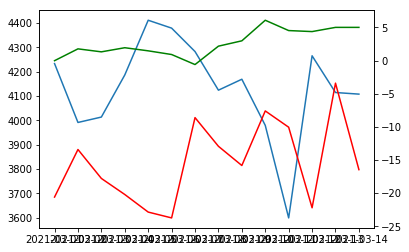

In [60]:
dates = sorted(list(set(vdf['date'])))

weights = []
thetas = []
phis = []

for date in dates:
    vdf2 = vdf[(vdf.date == date)]
    weights.append(np.mean(vdf2['estimated_weight_g']))
    thetas.append(np.mean(vdf2['theta']))
    phis.append(np.mean(vdf2['phi']))
    
    
fig, ax = plt.subplots()
ax2 = ax.twinx()

ax.plot(dates, weights)
ax2.plot(dates, thetas, color = 'red')
ax2.plot(dates, phis, color = 'green')

2021-03-15 4789.657109025596 471 69
2021-03-16 4880.702901317412 528 83
2021-03-17 4980.9264912400195 1517 186
2021-03-18 4921.637690028461 1924 307
2021-03-19 5257.1571292103945 1232 185
2021-03-20 5005.3619453932515 1622 187
2021-03-21 4847.244584287693 1650 306
2021-03-22 5131.372582104246 841 59
2021-03-23 5227.694568388602 805 68
2021-03-24 4919.285376866658 371 48
2021-03-25 4825.162280534135 1661 244
2021-03-26 4951.936902685298 990 144
2021-03-27 5051.886907645634 987 91
2021-03-28 5202.0679321782345 1243 145
2021-03-29 4869.129789629202 973 87
2021-03-30 5011.501991631169 1366 152
2021-03-31 4979.78878655256 2246 416
2021-04-01 5108.98673797355 863 68
2021-04-02 4999.292141976136 2489 606
2021-04-03 5233.385558381226 722 66
2021-04-04 5055.09728634799 1019 108
2021-04-05 5021.516645132606 1246 201
2021-04-06 4722.79637267715 1100 171
2021-04-07 4749.7178141946915 1770 385
2021-04-08 4972.030697390437 420 32


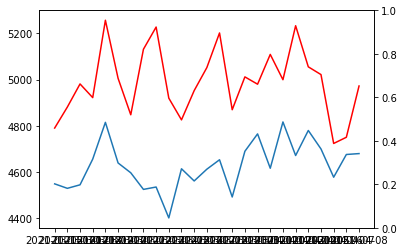

In [84]:
dates = sorted(list(set(ddf['date'])))

weights = []
weights_filtered = []
thetas = []
phis = []

for date in dates:
    ddf2 = ddf[(ddf.date == date) & (ddf.hour >= 9) & (ddf.hour <= 15)]
    ddf3 = ddf[(ddf.date == date) & (ddf.hour >= 9) & (ddf.hour <= 15) & (np.abs(ddf['theta']) < 10)]

    print(date, np.mean(ddf3['estimated_weight_g']), len(ddf2), len(ddf3))
    
    weights.append(np.mean(ddf2['estimated_weight_g']))
    weights_filtered.append(np.mean(ddf3['estimated_weight_g']))
    thetas.append(np.mean(ddf2['theta']))
    phis.append(np.mean(ddf2['phi']))
    
    
fig, ax = plt.subplots()
ax2 = ax.twinx()

ax.plot(dates, weights)
ax.plot(dates, weights_filtered, color = 'red')
# ax2.plot(dates, thetas, color = 'red')
# ax2.plot(dates, phis, color = 'green')

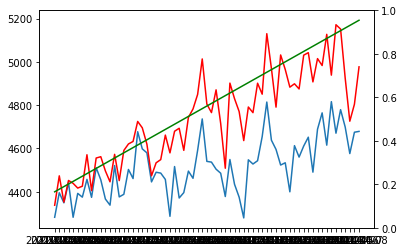

In [105]:
dates = sorted(list(set(vdf['date'])))

weights = []
weights_filtered = []
thetas = []
phis = []

for date in dates:
    ddf2 = vdf[(vdf.date == date) & (vdf.hour >= 9) & (vdf.hour <= 15)]
    ddf3 = vdf[(vdf.date == date) & (vdf.hour >= 9) & (vdf.hour <= 15) & (np.abs(vdf['theta']) < 20)]

#     print(date, np.mean(ddf3['estimated_weight_g']), len(ddf2), len(ddf3))
    
    weights.append(np.mean(ddf2['estimated_weight_g']))
    weights_filtered.append(np.mean(ddf3['estimated_weight_g']))
    thetas.append(np.mean(ddf2['theta']))
    phis.append(np.mean(ddf2['phi']))
    
    
fig, ax = plt.subplots()
ax2 = ax.twinx()

x = np.arange(0, len(dates))
y = 4400 + 12 * x

ax.plot(dates, weights)
ax.plot(dates, weights_filtered, color = 'red')
ax.plot(x, y, color = 'green')
# ax2.plot(dates, thetas, color = 'red')
# ax2.plot(dates, phis, color = 'green')

In [93]:
print(y[-1])

5192


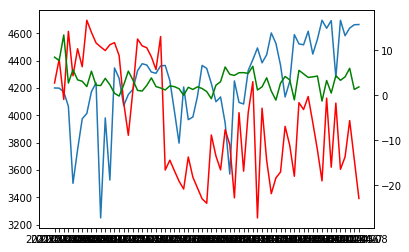

In [94]:
dates = sorted(list(set(vdf['date'])))

weights = []
thetas = []
phis = []

for date in dates:
    ddf2 = vdf[(vdf.date == date)]
    weights.append(np.mean(ddf2['estimated_weight_g']))
    thetas.append(np.mean(ddf2['theta']))
    phis.append(np.mean(ddf2['phi']))
    
    
fig, ax = plt.subplots()
ax2 = ax.twinx()

ax.plot(dates, weights)
ax2.plot(dates, thetas, color = 'red')
ax2.plot(dates, phis, color = 'green')

(array([0.00000000e+00, 1.00553914e-05, 3.26800222e-05, 5.02769572e-05,
        1.48317024e-04, 2.63954025e-04, 3.16744831e-04, 3.16744831e-04,
        4.17298745e-04, 3.34341766e-04, 2.23732460e-04, 1.35747785e-04,
        8.04431316e-05, 6.78738923e-05, 3.26800222e-05, 1.00553914e-05,
        7.54154359e-06, 5.02769572e-06, 1.00553914e-05, 2.51384786e-06]),
 array([1665.66193104, 2071.16299868, 2476.66406631, 2882.16513395,
        3287.66620159, 3693.16726923, 4098.66833687, 4504.16940451,
        4909.67047215, 5315.17153978, 5720.67260742, 6126.17367506,
        6531.6747427 , 6937.17581034, 7342.67687798, 7748.17794561,
        8153.67901325, 8559.18008089, 8964.68114853, 9370.18221617,
        9775.68328381]),
 <a list of 20 Patch objects>)

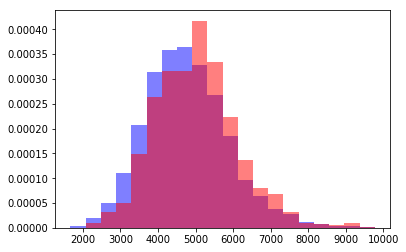

In [102]:
date = '2021-04-02'
date2 = '2021-04-05'
ddf2 = vdf[(vdf.date >= date) & (vdf.date <= date2) & (vdf.hour >= 9) & (vdf.hour <= 15)]
ddf3 = vdf[(vdf.date >= date) & (vdf.date <= date2) & (vdf.hour >= 9) & (vdf.hour <= 15) & (np.abs(vdf['theta']) < 10)]


counts, bins, _ = plt.hist(ddf2.estimated_weight_g, density = True, color = 'blue', bins = 20, alpha = 0.5)
plt.hist(ddf3.estimated_weight_g, density = True, color = 'red', bins = bins, alpha = 0.5)